This notebook contains a working example show usage of the new
image similarity based saliency map API for choosing to use 
a occlusion based saliency map algorithm.

Packages required for the below example

- python 3.7 and above
- jupyter
- matplotlib
- torch
- torchvision
- PIL
- scikit-learn
- numpy
- xaitk_saliency

Note: it is not unusual for the below code to throwback a warning 
indicating missing psycopg2 and caffe modules.
Please disregard any such warnings. 

Reference for implementation: Dong B, Collins R, Hoogs A.
Explainability for Content-Based Image Retrieval.
InCVPR Workshops 2019 Jun (pp. 95-98).

In [1]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindowPerturb
from xaitk_saliency.impls.vis_sal_similarity.similarityscoring import SimilarityScoring

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import torchvision.models as models
import torch
import numpy as np
from torch import nn


# Test image to be explained
test_image1_path = 'catdog.png'
test_image2_path = 'dog.jpg'

# Constructing xaitk implementations for SimilarityBased Saliency genration with
# sliding windows.
slid_algo = SlidingWindowPerturb(window_size=(24, 24), stride=(5, 5), threads=4)
similarity_alg = SimilarityScoring()


# Creating an example deep feature extractor to describe images
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])
model = model.eval()
model = model.cuda()

In [2]:
# Input image loader to match feature extractor expectation
imsize = 224
loader = transforms.Compose([transforms.Resize((imsize)), transforms.ToTensor()])

def image_loader(image_name):
    try:
        image = Image.open(image_name)
    except AttributeError:
        # If Image already open
        image = image_name
    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    return image.cuda().unsqueeze(0)

def predict_with_model(model, image_tensor):
    featureVec = model(image_tensor)
    return featureVec.cpu().detach().numpy().squeeze()

def compute_prtb_feats(p_image):
    # Use created sliding window based perturbation algorithm to perturb test image
    pert_img = []
    pertmask = []
    prtbd_feat = []
    for i, (img, mask) in enumerate(slid_algo(p_image)):
        pertmask.append(mask)
        pert_img.append(img)
    # Compute feature vectors on perturbed version of the test image
    prtbd_feat = np.array([predict_with_model(model, image_loader(ptrbed)) for ptrbed in pert_img])
    return np.array(pertmask), prtbd_feat

# Test images containing cat and dog.
test_image1 = Image.open(test_image1_path).resize((imsize, imsize))
test_image2 = Image.open(test_image2_path).resize((imsize, imsize))

# Compute original feature vector on test images
org_feat_1 = predict_with_model(model, image_loader(test_image1))
org_feat_2 = predict_with_model(model, image_loader(test_image2))

# Perturb both test images
pertmask1, prtbd_feat1 = compute_prtb_feats(test_image1)
pertmask2, prtbd_feat2 = compute_prtb_feats(test_image2)

# Generating final saliency map for all permutations of two test images
local_var = locals()
perm1 = [1, 1, 2, 2]
perm2 = [1, 2, 1, 2]

for plt_i, (q_n, r_n) in enumerate(zip(perm1, perm2)):
    local_var['img{}_img{}_sal'.format(q_n, r_n)] = similarity_alg(
                                local_var['org_feat_{}'.format(q_n)],
                               local_var['org_feat_{}'.format(r_n)],
                               local_var['prtbd_feat{}'.format(r_n)],
                               local_var['pertmask{}'.format(r_n)])[0]

/home/khq.kitware.com/bhavan.vasu/.conda/envs/xaitk/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':
/home/khq.kitware.com/bhavan.vasu/.conda/envs/xaitk/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


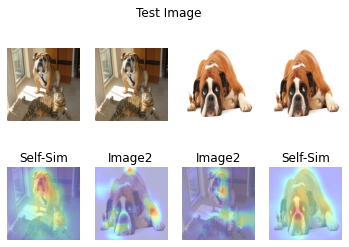

In [3]:
"""Visualize salient regions between two images and themself.
  Self-similarity indicates salient regions encoded
  in the feature vector while SBSM between two images indicates
  saliency regions across two test images."""
fig = plt.figure()

for plt_i, (q_n, r_n) in enumerate(zip(perm1, perm2)):
    fig.suptitle("Test Image", fontsize=12)
    ax = plt.subplot("24{}".format(int(plt_i + 1)))
    plt.imshow(local_var['test_image{}'.format(q_n)])
    plt.axis('off')
    ax = plt.subplot("24{}".format(int(plt_i + 5)))
    if q_n == r_n:
        ax.set_title('Self-Sim')
    else:
        ax.set_title('Image2')
    plt.imshow(local_var['test_image{}'.format(r_n)], alpha=0.5)
    plt.imshow((local_var['img{}_img{}_sal'.format(q_n, r_n)]), cmap='jet', alpha=0.3)
    plt.axis('off')
plt.show()